In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")
import copy
import os
import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation
import json

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

from dataclasses import dataclass
from collections import OrderedDict

@dataclass
class LayerRewriteResult:
    layer_idx: int
    score: float
    efficacy: float
    generalization: float
    specificity: float

In [16]:
import matplotlib.pyplot as plt
import numpy as np

#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+2)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE-2)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

from typing import Optional

def layername(i, jump=5):
    if i % jump == 0:
        return str(i)
    else:
        return ""

def visulize_sweep_results(
    module_wise_results: dict[int, LayerRewriteResult],
    savepdf: Optional[str] = None,
):
    metric_title = {
        "efficacy": {"title": "Efficacy (ES)"},
        "generalization": {"title": "Generalization (PS)"},
        "specificity": {"title": "Specificity (NS)"},
        "score": {"title": "Score (S)"},
    }

    module_color = {
        "in_proj/ssm": "firebrick",
        "in_proj/non_ssm": "green",
        "out_proj": "blue",
        "dense_4h_to_h": "#004c4c"
    }

    fig, ax = plt.subplots(1, 4, figsize=(20, 4))

    for module in module_wise_results:
        layer_results = module_wise_results[module]
        layers = sorted(list(layer_results.keys()))
        data = {
            "efficacy": [layer_results[layer].efficacy for layer in layers],
            "generalization": [layer_results[layer].generalization for layer in layers],
            "specificity": [layer_results[layer].specificity for layer in layers],
            "score": [layer_results[layer].score for layer in layers],
        }
        
        for canvas, (k, v) in zip(ax, data.items()):
            canvas.plot(
                layers, v,
                marker="o",
                markersize=2.2,
                linewidth=2,
                alpha=0.7,
                color=module_color[module],
                label=module if k == "efficacy" else None,
            )
            canvas.set_title(k)
            canvas.set_xlabel("Edit Layer")
            # canvas.set_ylabel("Score")
            canvas.set_title(metric_title[k]["title"])
            canvas.set_ylim(0, 108)
            layer_names = [
                str(l) if i%5 == 0 else "" for i, l in enumerate(layers)
            ]
            canvas.set_xticks(layers, layer_names)
            canvas.set_yticks(np.arange(0, 110, 25))

    fig.legend(ncol = 3, bbox_to_anchor=(0.5, -.13), loc='lower center', frameon=False)
    fig.tight_layout()

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        fig.savefig(savepdf, bbox_inches="tight", dpi=300)

    fig.show()

In [4]:
from scripts.summarize import main as summarize
from pathlib import Path
from typing import Optional, Literal

MODEL_INFO = {
    "pythia-2.8b-deduped": {
        "n_layer": 32,
        "dirs": ["dense_4h_to_h"],
        "hparams": "pythia-3b.json",
        "known_data": "data/known/pythia-2.8b-deduped.json"
    },
    "mamba-2.8b": {
        "n_layer": 64,
        # "rewrite_module": "layers.{}.mixer.out_proj"
        # "rewrite_module": "layers.{}.mixer.in_proj",
        "dirs": ["in_proj/ssm", "in_proj/non_ssm", "out_proj"],
        "hparams": "mamba-3b.json",
        "known_data": "data/known/mamba-2.8b.json"
    }
}

#############################################################
ROME_DIR = "../../results/ROME/"
# MODEL = "pythia-2.8b-deduped"
MODEL = "mamba-2.8b"
#############################################################

In [5]:
rewrite_matrix = MODEL_INFO[MODEL]["dirs"][0]
sweep_dir = os.path.join(ROME_DIR, MODEL, rewrite_matrix)
# os.listdir(sweep_dir)

In [6]:
module_wise_results = {module: OrderedDict() for module in MODEL_INFO[MODEL]["dirs"]}

for module in MODEL_INFO[MODEL]["dirs"]:
    sweep_dir = os.path.join(ROME_DIR, MODEL, module)

    for layer_folder in os.listdir(sweep_dir):
        summary = summarize(
            dir_name=Path(sweep_dir) / layer_folder,
            # runs=["run_000"],
            abs_path=True
        )[0]
        layer_idx = int(layer_folder.split("_")[-1])
        module_wise_results[module][layer_idx] = LayerRewriteResult(
            layer_idx=layer_idx,
            score=summary["post_score"][0],
            efficacy=summary["post_rewrite_success"][0],
            generalization=summary["post_paraphrase_success"][0],
            specificity=summary["post_neighborhood_success"][0]
        )

{'num_cases': 2000,
 'post_neighborhood_acc': (38.86, 29.76),
 'post_neighborhood_diff': (20.07, 16.91),
 'post_neighborhood_success': (88.98, 18.55),
 'post_paraphrase_acc': (20.12, 31.64),
 'post_paraphrase_diff': (5.6, 24.0),
 'post_paraphrase_success': (49.9, 42.01),
 'post_rewrite_acc': (97.3, 16.21),
 'post_rewrite_diff': (90.0, 20.36),
 'post_rewrite_success': (98.3, 12.93),
 'post_score': (72.37373676528739, nan),
 'run_dir': '../../results/ROME/mamba-2.8b/in_proj/ssm/layer_0/run_000',
 'time': (31.81923440468311, 9.84881302160361)}
{'num_cases': 2000,
 'post_neighborhood_acc': (37.73, 28.95),
 'post_neighborhood_diff': (18.3, 16.56),
 'post_neighborhood_success': (86.49, 20.55),
 'post_paraphrase_acc': (57.03, 41.34),
 'post_paraphrase_diff': (42.52, 34.86),
 'post_paraphrase_success': (91.5, 22.59),
 'post_rewrite_acc': (99.95, 2.24),
 'post_rewrite_diff': (96.01, 6.4),
 'post_rewrite_success': (100.0, 0.0),
 'post_score': (92.33328413611335, nan),
 'run_dir': '../../results/

In [7]:
module_wise_results.keys()

dict_keys(['in_proj/ssm', 'in_proj/non_ssm', 'out_proj'])

In [8]:
# module_wise_results["in_proj/ssm"]

2024-04-02 16:08:47 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-04-02 16:08:47 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-04-02 16:08:47 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


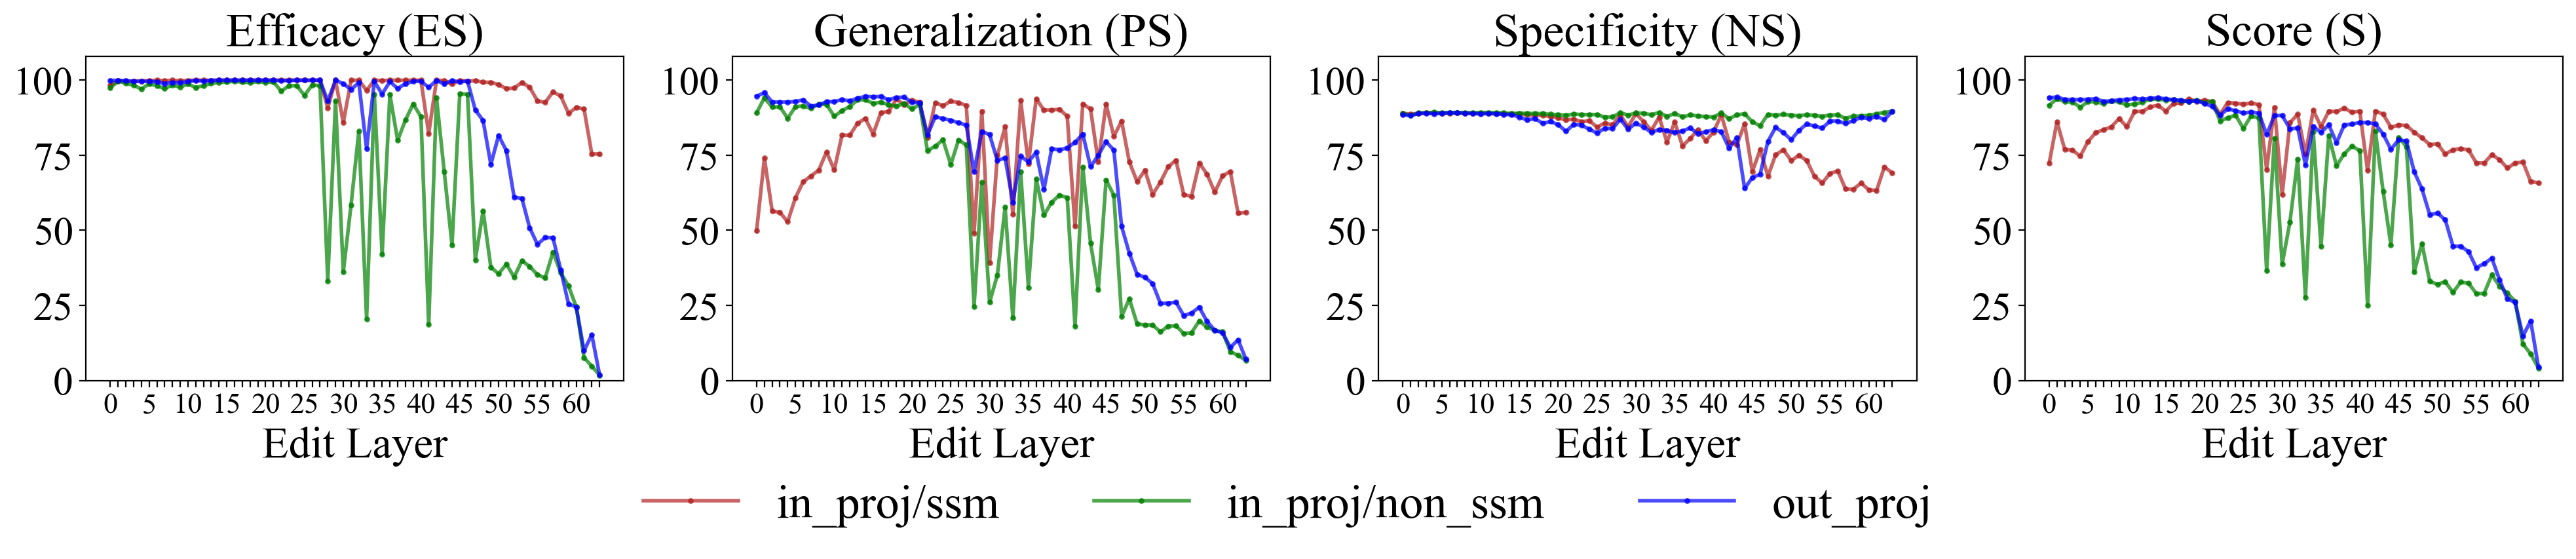

In [18]:
visulize_sweep_results(
    module_wise_results,
    savepdf=f"../../Figures/ROME/{MODEL}_sweep.pdf"
)